# 识别手写体/印刷体数字的分类器 #
reference https://lhy.io/digit_recognition/ 
dataset http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

In [1]:
from helper import *
import tensorflow as tf
import os

imgDir = '../../data/EnglishFnt/'

def shuffleData(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices,:,:,:]
    y = y[indices]
    sep = int(0.8 * len(X))
    x_train = X[:sep,:,:,:]
    y_train = y[:sep]
    x_test = X[sep:,:,:]
    y_test = y[sep:]
    return (x_train, y_train), (x_test, y_test)

def gray2binary(gray, threshold):
    bw = gray
    idx1 = gray <= threshold
    idx2 = gray >= threshold
    bw[idx1] = 255
    bw[idx2] = 0
    return bw

## load printed dataset ##

In [47]:
# original size
# nh = 128, nw = 128
nh = 24 
nw = 24

data = []
label = []

for s in os.listdir(imgDir):
    if s[6:].isdigit():
        y = int(s[6:])
    else:
        continue
    if (y == 4 or y > 5):
        continue
    subdir = os.path.join(imgDir, s)
    samples = load_image_png(subdir, nh, nw)
    t = np.ones(len(samples), dtype=np.uint8) * (y - 1)
    data.append(samples)
    label.append(t)
    print(samples.shape)
    
data = np.array(data)
data = np.reshape(data, (1016 * 4, nh, nw, 1))

label = np.array(label)
label = np.reshape(label, 1016 * 4)

data = gray2binary(data, 127)
data = data / 255.0

/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1016, 24, 24)
(1016, 24, 24)
(1016, 24, 24)
(1016, 24, 24)


## 扩充数据集 ##

In [ ]:
for k in range(2):
    augdata = np.zeros((n * 4, nh, nw, 1))
    shift = (k + 1) * 4
    
    augdata[  0:  n, :, 0:nw-shift, :] = data[:n, :, shift:nw, :]
    augdata[  n:2*n, :, shift:nw, :] = data[:n, :, 0:nw-shift, :]
    augdata[2*n:3*n, 0:nh-shift, :, :] = data[:n, shift:nh, :, :]
    augdata[3*n:4*n, shift:nh, :, :] = data[:n, 0:nh-shift, :, :]
    augy = label[:n]
    
    data = np.concatenate((data, augdata), axis=0)
    label = np.hstack((label, np.tile(augy, 4)))   

In [51]:
# 数据集扩充
# 平移
nh = 24
nw = 24
shift = 4

n = len(data)

for i in range(-2, 3):
    kx = i * shift
    if kx >= 0:
        ix1, ix2 = 0, nh - kx
    else:
        ix1, ix2 = -kx, nh
    jx1, jx2 = ix1 + kx, ix2 + kx
        
    for j in range(-2, 3):
        if i == 0 and j == 0:
            continue
        if abs(i) == 2 and abs(j) == 2:
            continue
        
        ky = j * shift
        if ky >= 0:
            iy1, iy2 = 0, nw - ky
        else:
            iy1, iy2 = -ky, nw
        jy1, jy2 = iy1 + ky, iy2 + ky
        
        augdata = np.zeros((n, nh, nw, 1))
        augdata[:, ix1:ix2, iy1:iy2, :] = data[:n, jx1:jx2, jy1:jy2, :]
        
        augy = label[:n]
    
        data = np.concatenate((data, augdata), axis=0)
        label = np.hstack((label, augy))   

In [52]:
print(data.shape)
print(data.shape, label.shape)
print(label)
for i in range(-2, 3):
    print(i)

(85344, 24, 24, 1)
(85344, 24, 24, 1) (85344,)
[0 0 0 ... 4 4 4]
-2
-1
0
1
2


In [53]:
print(np.min(data), np.max(data))

samples = data
(x_train, y_train),(x_test, y_test) = shuffleData(samples, label)

0.0 1.0


## load handwrite digit dataset & merge ##

In [55]:
from load_mnist import loadmnist
(x1_train, y1_train),(x1_test, y1_test) = loadmnist()

In [56]:
print(x_train.shape, y_train.shape)
print(x1_train.shape, y1_train.shape)

(68275, 24, 24, 1) (68275,)
(24465, 28, 28) (24465,)


In [58]:
label_train = y_train.copy()
y_train[label_train == 4] = 3

label_test = y_test.copy()
y_test[label_test == 4] = 3

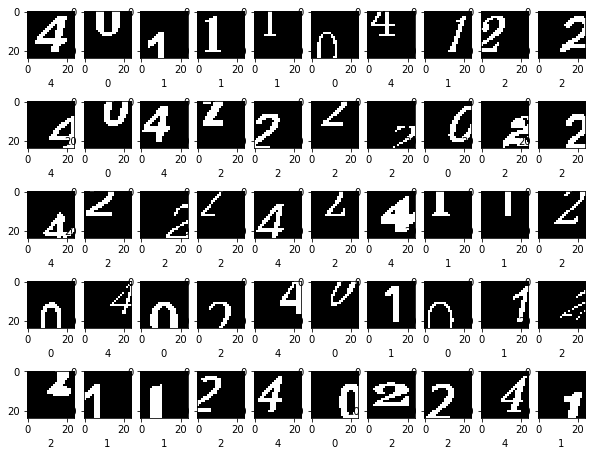

In [60]:
import random
import matplotlib.pyplot as plt

fm = 5
fn = 10

plt.figure(figsize=(10, 8))

for i in range(fm):
    for j in range(fn):

        k = random.randint(0, len(y_test))
        pic = np.reshape(x_test[k, :, :, :], (nh, nh))

        plt.subplot(fm, fn, i * fn + j + 1)
        plt.imshow(pic, cmap='gray')
        plt.xlabel(label_test[k])
    
plt.show()

## train a dnn model ##

In [102]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=64, epochs=20)
model.evaluate(x_test, y_test)

model.save('model.h5')

Epoch 1/20
68275/68275 [==============================] - 8s 117us/step - loss: 0.8591 - acc: 0.6456
Epoch 2/20
68275/68275 [==============================] - 2s 32us/step - loss: 0.5305 - acc: 0.8109
Epoch 3/20
68275/68275 [==============================] - 2s 32us/step - loss: 0.4598 - acc: 0.8386
Epoch 4/20
68275/68275 [==============================] - 2s 31us/step - loss: 0.4286 - acc: 0.8505
Epoch 5/20
68275/68275 [==============================] - 2s 32us/step - loss: 0.4080 - acc: 0.8588
Epoch 6/20
68275/68275 [==============================] - 2s 33us/step - loss: 0.3969 - acc: 0.8616
Epoch 7/20
68275/68275 [==============================] - 2s 32us/step - loss: 0.3854 - acc: 0.8665
Epoch 8/20
68275/68275 [==============================] - 2s 36us/step - loss: 0.3776 - acc: 0.8690
Epoch 9/20
68275/68275 [==============================] - 2s 33us/step - loss: 0.3713 - acc: 0.8703
Epoch 10/20
68275/68275 [==============================] - 2s 33us/step - loss: 0.3695 - acc: 0.872

In [101]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout

print(x_train.shape)

input_tensor = Input(shape=(128, nh, nw, 1), name="input")
x = Flatten()(input_tensor)
x = Dense(16, activation=tf.nn.relu)(x)
x = Dropout(0.2)(x)
x = Dense(16, activation=tf.nn.relu)(x)
x = Dropout(0.2)(x)
x = Dense(4, activation=tf.nn.softmax)(x)
model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=64, epochs=1)
model.evaluate(x_test, y_test)

model.save('model.h5')

(68275, 24, 24, 1)


ValueError: Error when checking input: expected input to have 5 dimensions, but got array with shape (68275, 24, 24, 1)

## train a CNN model ##

In [74]:
model_c = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(24, 24, 1), padding='same'),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
  #tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_c.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_c.fit(x_train, y_train, epochs=5)
model_c.evaluate(x_test, y_test)
model_c.save('model_c.h5')

Epoch 1/5
68275/68275 [==============================] - 20s 298us/step - loss: 0.3378 - acc: 0.8908
Epoch 2/5
68275/68275 [==============================] - 21s 303us/step - loss: 0.1462 - acc: 0.9551
Epoch 3/5
68275/68275 [==============================] - 20s 292us/step - loss: 0.1004 - acc: 0.9680
Epoch 4/5
68275/68275 [==============================] - 20s 287us/step - loss: 0.0768 - acc: 0.9748
Epoch 5/5
17069/17069 [==============================] - 2s 96us/step


[0.09059876371697757, 0.970062686742047]

In [114]:
print(np.min(x_test), np.max(x_test))

0.0 1.0


# TEST DATA #
collect from small vehicle

In [64]:
gc = 127
nh = 24
nw = 32

samples = load_image("./test", nh, nw)
n = len(samples)

x_real = preprocess(samples, 4, 127)
x_real = np.reshape(x_real, (n, nh, nh, 1))
y_real = [1, 1, 1, 1, 3, 0, 1, 2]

/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/wuyan/anaconda2/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Predict with DNN model##

In [103]:
print(model.evaluate(x_real, y_real))

y_pred = model.predict(x_real).argmax(1)
y_label = y_pred
y_label[y_pred == 3] = 4
print(y_pred)

8/8 [==============================] - 0s 245us/step
[1.0180444717407227, 0.875]
[1 1 1 0 4 0 1 2]


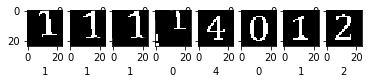

In [104]:
for i in range(n):
    plt.subplot(1, n, i + 1)

    pic = np.reshape(x_real[i,:,:,:], (nh, nh))
    
    plt.imshow(pic, cmap='gray')
    plt.xlabel(str(y_label[i]))
    
plt.show()

## Predict with CNN model ##

In [77]:
print(model_c.evaluate(x_real, y_real))

y_pred = model_c.predict(x_real).argmax(1)
y_label = y_pred
y_label[y_pred == 3] = 4
print(y_pred)

8/8 [==============================] - 0s 277us/step
[2.36567759513855, 0.75]
[1 1 0 0 4 0 1 2]


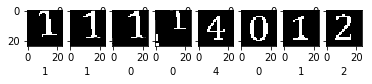

In [78]:
for i in range(n):
    plt.subplot(1, n, i + 1)

    pic = np.reshape(x_real[i,:,:,:], (nh, nh))
    
    plt.imshow(pic, cmap='gray')
    plt.xlabel(str(y_label[i]))
    
plt.show()

In [174]:
print(len(y_train), len(y_test))

3251 813


## model ouput##

Java 调用Keras和tensorflow模型
https://www.jianshu.com/p/0016a34c82c8

In [79]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    :param session: 需要转换的tensorflow的session
    :param keep_var_names:需要保留的variable，默认全部转换constant
    :param output_names:output的名字
    :param clear_devices:是否移除设备指令以获得更好的可移植性
    :return:
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        # 如果指定了output名字，则复制一个新的Tensor，并且以指定的名字命名
        if len(output_names) > 0:
            for i in range(output_names):
                # 当前graph中复制一个新的Tensor，指定名字
                tf.identity(model.model.outputs[i], name=output_names[i])
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [110]:
from keras import backend as K
from keras.models import load_model
import tensorflow as tf

# del model

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.load_model("model.h5")
model = load_model('model.h5')

print(model.input.op.name)
print(model.output.op.name)

# 自定义output_names
frozen_graph = freeze_session(K.get_session(), output_names=["output"])
tf.train.write_graph(frozen_graph, "./", "model.pb", as_text=False)

### 输出：
# input
# output_softmax/Softmax
# 如果不自定义output_name，则生成的pb模型的output_name为output_softmax/Softmax，如果自定义则以自定义名为output_name

ValueError: You are trying to load a weight file containing 3 layers into a model with 0 layers.